In [11]:
# Import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Set memory growth to avoid cuda errors
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
img_align_celeba = keras.preprocessing.image_dataset_from_directory(
    directory="D:/GAN/img_align_celeba", label_mode=None, image_size=(64, 64), batch_size=25,
    shuffle=True, seed=None, validation_split=None,
).map(lambda x: x / 255.0) # Normalizing: All pixel values are between 0 to 1 after mapping
# label = None, since it is unsupervised

Found 202599 files belonging to 1 classes.


In [4]:
type(img_align_celeba)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [5]:
print("GPUs Available: ", tf.config.list_physical_devices('GPU')) # Checking for GPU

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


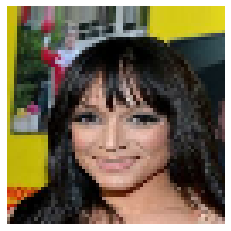

In [6]:
# Show a random picture from the celebA dataset
for x in img_align_celeba:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [33]:
# Discriminator maps images in img_align_celeba dataset (64x64 size) 
# to a binary classification score

# Sequential model
# Discriminator will take input image and output a number between 0 and 1 
# indicating if it's fake or real.
# Fake = 0 and Real = 1
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)), # 64x64x3
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"), 
        # "same" padding so that o/p image = i/p image
        layers.LeakyReLU(alpha=0.2), 
        # activation layer that is Leaky version of a Rectified Linear Unit.
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"), 
        # Dense layer of 1 node -> o/p 0 to 1 since sigmoid
    ],
    name="discriminator",
)

latent_dim = 128
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)), # creates 8x8 image
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"), 
        # to make image larger for generator 
        # After this layer picture is (16x16)
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        # After this layer picture is (32x32)
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        # After this layer picture is (64x64)
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [8]:
opt_gen = keras.optimizers.Adam(0.0001) # Learning rate = 0.0001
opt_disc = keras.optimizers.Adam(0.0001)
loss_fn = keras.losses.BinaryCrossentropy() # Loss function

In [13]:
try: 
    for epoch in range(10):
        for idx, (real) in enumerate(tqdm(img_align_celeba)):
            batch_size = real.shape[0]
            # To create random latent vector
            with tf.GradientTape() as gen_tape:
                random_latent_vectors = tf.random.normal(shape = (batch_size, latent_dim))
                fake = generator(random_latent_vectors)

            if idx % 250 == 0:
                img = keras.preprocessing.image.array_to_img(fake[0])
                img.save("D:/GAN/genearted_images/generated_img_%03d_%d.png" % (epoch, idx))

            # Train Discriminator: max y*log(D(x)) + (1-y) * log(1 - D(G(z))
            with tf.GradientTape() as disc_tape:
                loss_disc_real = loss_fn(tf.ones((batch_size, 1)), discriminator(real))
                loss_disc_fake = loss_fn(tf.zeros((batch_size, 1)), discriminator(fake))
                loss_disc = (loss_disc_real + loss_disc_fake)/2 # Averaging losses 
            
            # To update the weights and apply gradient
            grads = disc_tape.gradient(loss_disc, discriminator.trainable_weights)
            opt_disc.apply_gradients(
                zip(grads, discriminator.trainable_weights)
            )

            # Train Generator: min log(1 - D(G(z))) 
            with tf.GradientTape() as gen_tape:
                fake = generator(random_latent_vectors)
                output = discriminator(fake)
                loss_gen = loss_fn(tf.ones(batch_size, 1), output)
            
            # Compute gradients w.r.t loss of generator
            grads = gen_tape.gradient(loss_gen, generator.trainable_weights)
            opt_gen.apply_gradients(zip(grads, generator.trainable_weights))
except KeyboardInterrupt:
    pass

  0%|                                                                              | 2/8104 [00:43<48:44:26, 21.66s/it]


In [21]:
gen_image = keras.preprocessing.image_dataset_from_directory(
    directory="D:/GAN/genearted_images", label_mode=None, image_size=(64, 64), 
    shuffle=False, seed=None, validation_split=None,
)

Found 68 files belonging to 1 classes.


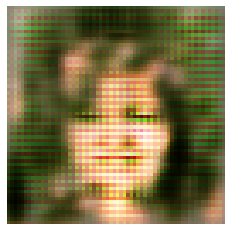

In [24]:
# Show generated face #1
for x in gen_image:
    plt.axis("off")
    plt.imshow(x.numpy().astype("int32")[-12])
    break

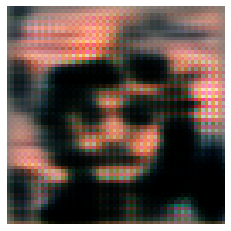

In [32]:
# Show generated face #2
for x in gen_image:
    plt.axis("off")
    plt.imshow(x.numpy().astype("int32")[-22])
    break

**Code Reference: https://keras.io/examples/generative/dcgan_overriding_train_step/**